# üìö Book Cluster Explorer

Exploring themes in novels using embeddings, clustering, and summarization.

### Dataset
- [Pride and Prejudice](https://www.gutenberg.org/ebooks/1342) ‚Äî Jane Austen  
- [Frankenstein](https://www.gutenberg.org/ebooks/84) ‚Äî Mary Shelley  
- [Moby-Dick](https://www.gutenberg.org/ebooks/2701) ‚Äî Herman Melville  

### Workflow
1. Download & preprocess text  
2. Chunk into passages with metadata (book + author)  
3. Generate embeddings (Universal Sentence Encoder)  
4. Cluster passages with KMeans  
5. Summarize clusters (extractive TF-IDF)  
6. Visualize in 2D  

In [1]:
!pip install tensorflow tensorflow-hub scikit-learn pandas matplotlib requests sentence-transformers

## 1. Download books

In [2]:
import requests

In [3]:
books = [
        {"title": "Pride and Prejudice", "author": "Jane Austen", "url": "https://www.gutenberg.org/files/1342/1342-0.txt"},
        {"title": "Frankenstein", "author": "Mary Shelley", "url": "https://www.gutenberg.org/files/84/84-0.txt"},
        {"title": "Moby-Dick", "author": "Herman Melville", "url": "https://www.gutenberg.org/files/2701/2701-0.txt"},
    ]
for book in books:
    r = requests.get(book["url"])
    r.raise_for_status()
    fname = book["title"].replace(" ","_").lower() + ".txt"
    with open("data/novels/" + fname, "w", encoding="utf-8") as f:
        f.write(r.text),
print("Downloaded books.")

Downloaded books.


## 2. Preprocess and chunk with metadata

In [16]:
import re
from pathlib import Path

def strip_gutenberg_markers(text):
    text = text.replace("CHAPTER", "")
    start = re.search(r"\*\*\* *START OF THE PROJECT GUTENBERG EBOOK.*\*\*\*", text, flags=re.I)
    end = re.search(r"\*\*\* *END OF THE PROJECT GUTENBERG EBOOK.*\*\*\*", text, flags=re.I)
    if start and end:
        return text[start.end():end.start()].strip()
    return text

def chunk_text(text, chunk_size_words=200):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size_words):
        chunk = " ".join(words[i:i+chunk_size_words])
        chunks.append(chunk)
    return chunks

all_chunks = []

for book in books:
    fname = book["title"].replace(" ", "_").lower() + ".txt"
    text = Path("data/novels/"+fname).read_text(encoding="utf-8")
    text = strip_gutenberg_markers(text)
    chunks = chunk_text(text, chunk_size_words=250)
    for c in chunks:
        all_chunks.append({"book": book["title"], "author": book["author"], "text": c})

len(all_chunks)

1662

## 3. Embeddings

In [17]:
# Embedding and summarizer options
embedding_models = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "MPNet": "sentence-transformers/all-mpnet-base-v2"
}

summarizer_models = {
    "BART": "facebook/bart-large-cnn",
    "DistilBART": "sshleifer/distilbart-cnn-12-6",
    "T5": "t5-small" 
}

In [18]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [19]:
def safe_summarize_tokenizer(summarizer, tokenizer, text, max_input_tokens=512, **kwargs):
    if not text.strip():
        return "[No content to summarize]"

    # Tokenize and truncate
    inputs = tokenizer(text, max_length=max_input_tokens, truncation=True, return_tensors="pt")
    try:
        summary_ids = summarizer.model.generate(
            **inputs,
            max_length=kwargs.get("max_length", 120),
            min_length=kwargs.get("min_length", 30),
            do_sample=kwargs.get("do_sample", False)
        )
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        # Remove repeated phrases
        summary = re.sub(r'(\b\w+\b)( \1)+', r'\1', summary)
        return summary
    except Exception as e:
        return f"[Error in summarizer: {str(e)} | text_len={len(text.split())}]"

In [20]:
def run_summarization(chunks, sum_choice="BART", max_input_tokens=512, max_length=120, min_length=30, do_sample=False):
    tokenizer = AutoTokenizer.from_pretrained(summarizer_models[sum_choice])
    model = AutoModelForSeq2SeqLM.from_pretrained(summarizer_models[sum_choice])
    summarizer_pipeline = pipeline("summarization", model=model, tokenizer=tokenizer, device=-1)

    summaries = []
    for text in chunks:
        summary = safe_summarize_tokenizer(
            summarizer_pipeline,
            tokenizer,
            text,
            max_input_tokens=max_input_tokens,
            max_length=max_length,
            min_length=min_length,
            do_sample=do_sample
        )
        summaries.append(summary)
    return summaries

In [21]:
def run_experiment(chunks, emb_choice="MiniLM", sum_choice="BART", n_clusters=8):
    # Embed
    emb_model = SentenceTransformer(embedding_models[emb_choice])
    texts = [c["text"] for c in chunks]
    embeddings = emb_model.encode(texts, convert_to_tensor=False)

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings)

    # Summarize representative chunks
    summaries = []
    cluster_centers = kmeans.cluster_centers_
    for cluster_id in range(n_clusters):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        if not cluster_indices:
            summaries.append((cluster_id, "[Empty cluster]"))
            continue

        # Pick chunk closest to centroid
        import numpy as np
        centroid = cluster_centers[cluster_id]
        dists = [np.linalg.norm(embeddings[i]-centroid) for i in cluster_indices]
        rep_idx = cluster_indices[np.argmin(dists)]
        joined_text = texts[rep_idx]

        summary = run_summarization([joined_text], sum_choice=sum_choice)[0]
        summaries.append((cluster_id, summary))

    # Save results
    df = pd.DataFrame({"chunk": texts, "cluster": clusters})
    df.to_csv(f"data/results/results_{emb_choice}_{sum_choice}.csv", index=False)

    with open(f"data/results/summaries_{emb_choice}_{sum_choice}.txt", "w", encoding="utf-8") as f:
        for cid, summ in summaries:
            f.write(f"Cluster {cid} summary ({emb_choice}+{sum_choice}):\n{summ}\n---\n\n")

    # PCA visualization
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=clusters, cmap="tab10", s=10)
    plt.title(f"Clusters: {emb_choice} + {sum_choice}")
    plt.savefig(f"data/results/clusters_{emb_choice}_{sum_choice}.png")
    plt.show()

    return df, summaries

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


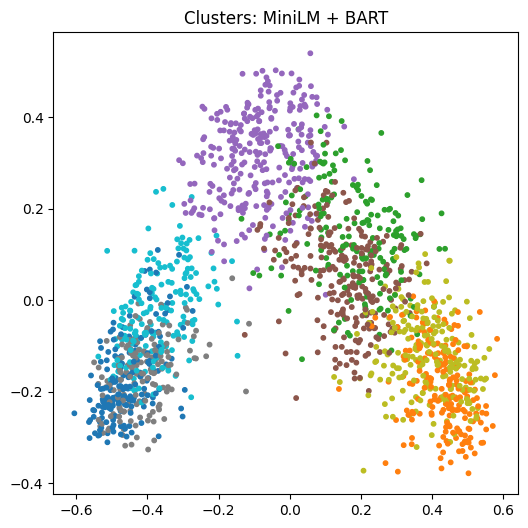

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


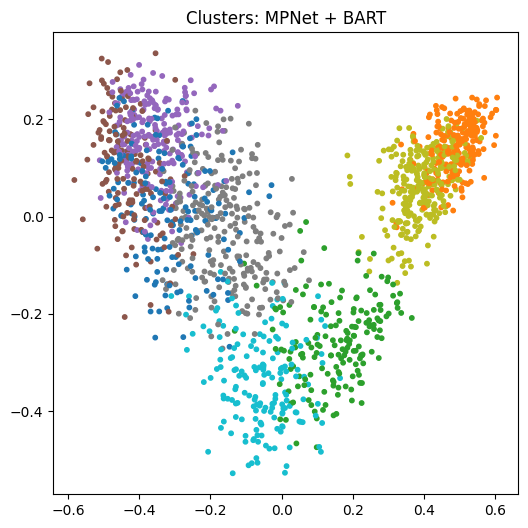

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


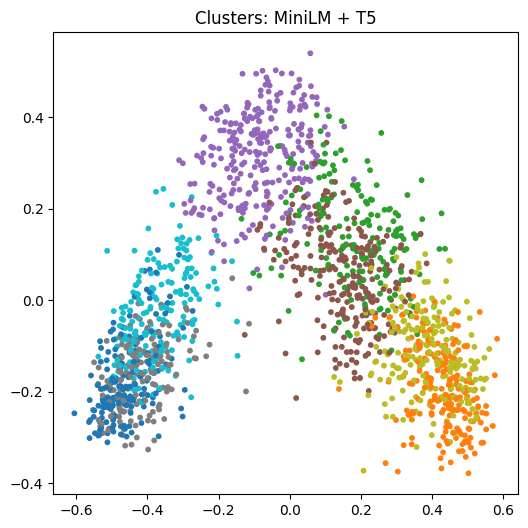

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


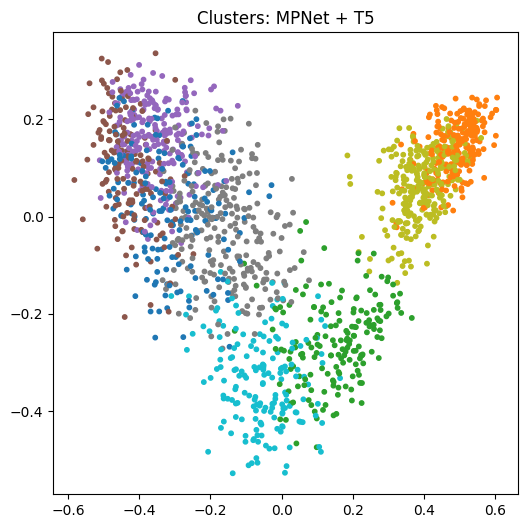

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


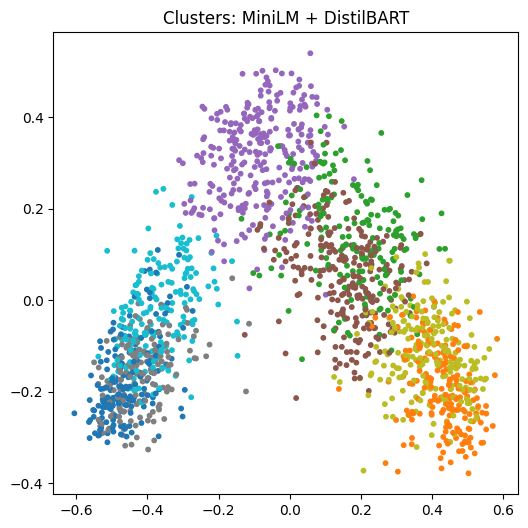

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


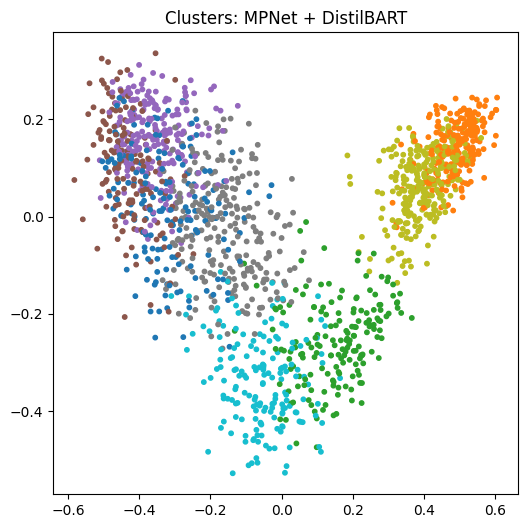

In [22]:
# Assuming you have your text chunks stored in `chunks` already
results = {}

# (1) MiniLM + BART
results["MiniLM_BART"] = run_experiment(all_chunks, "MiniLM", "BART")

# (2) MPNet + BART
results["MPNet_BART"] = run_experiment(all_chunks, "MPNet", "BART")

# (3) MiniLM + T5
results["MiniLM_T5"] = run_experiment(all_chunks, "MiniLM", "T5")

# (4) MPNet + T5
results["MPNet_T5"] = run_experiment(all_chunks, "MPNet", "T5")

# (5) MiniLM + DistilBART
results["MiniLM_DistilBART"] = run_experiment(all_chunks, "MiniLM", "DistilBART")

# (6) MPNet + DistilBART
results["MPNet_DistilBART"] = run_experiment(all_chunks, "MPNet", "DistilBART")


In [30]:
# Example: look at summaries for MPNet + Pegasus
for cid, summ in results["MiniLM_T5"][1]:
    print(f"Cluster {cid} summary:\n{summ}\n---\n")


Cluster 0 summary:
, and she was able to meet her sister, and she sat down again. both sisters were uncomfortable enough, and each felt for the other.
---

Cluster 1 summary:
, and,,,,,, the land in this matter, so the whale fishery surpasses every other sort of maritime life, in the wonderfulness and fearfulness of the rumors which sometimes circulate there. And as the sea surpasses the land in this matter, so the whale fishery surpasses every other sort of maritime life, in the wonderfulness and fearfulness of the rumors.
---

Cluster 2 summary:
, ye prouder, sadder souls! question that proud, sad king! A family likeness! aye, he did beget ye, ye young exiled royalties; and from your grim sire only will the old State-secret come.. he knew that to mankind he did long dissemble; in some sort, did still.. he knew that to mankind he did long dissemble; in some sort, did still.
---

Cluster 3 summary:
, and he had loitered in forests, hid himself in caves, or taken refuge in heaths. he ha